In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import arrow
from scipy.signal import savgol_filter 
import numpy as np
from lmfit.models import SkewedGaussianModel

In [7]:
# data from: http://ncov.mohw.go.kr/
df = pd.read_csv("all.csv").loc[1:].reset_index()
df["counts"] = [float(c.replace(",", "")) for c in df["계(명)"]]
df["savgol"] = savgol_filter([float(c.replace(",", "")) for c in df["계(명)"]], 7, 2)
df["ts"] = pd.to_datetime([str(arrow.get(t)) for t in df["일자"]])
df["rolling_avg"] = df["counts"].rolling(7).mean()
df.tail()

,index,일자,계(명),국내발생(명),해외유입(명),사망(명),Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,counts,savgol,ts,rolling_avg
800,801,2022.3.31,"320,743","320,719",24,375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,320743.0,355561.285714,2022-03-31 00:00:00+00:00,324741.714286
801,802,2022.4.1,"280,273","280,225",48,360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,280273.0,309466.428571,2022-04-01 00:00:00+00:00,316284.714286
802,803,2022.4.2,"264,171","264,103",68,336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,264171.0,264263.785714,2022-04-02 00:00:00+00:00,306088.428571
803,804,2022.4.3,"234,301","234,279",22,306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,234301.0,207102.357143,2022-04-03 00:00:00+00:00,294120.142857
804,805,2022.4.4,"127,190","127,184",6,218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127190.0,137982.142857,2022-04-04 00:00:00+00:00,285548.857143


In [3]:
def skewed_gaussian_fitting_n_plot(target_y, start_idx, df, show_stats=False):
    window_length = len(df) - start_idx
    april = pd.to_datetime([f"2022-04-{x}T00:00:00+00:00'" for x in range(1,31)]).to_list()
    may = pd.to_datetime([f"2022-05-{x}T00:00:00+00:00'" for x in range(1,32)]).to_list()
    whole_date = df["ts"].to_list() + april + may

    whole_date = sorted(list(set(whole_date)))
    xvals = np.arange(0, window_length)
    yvals = target_y[start_idx:]


    model = SkewedGaussianModel()

    # set initial parameter values
    params = model.make_params(amplitude=13639305., center=102.12, sigma=22.41, gamma=0)

    # adjust parameters  to best fit data.
    result = model.fit(yvals, params, x=xvals)
    
    if show_stats:
        print(result.fit_report())

    plt.figure(figsize=(6.5, 5))
    plt.title("fitting")
    plt.plot(xvals, yvals, 'd')
    ex = result.eval(x=xvals)
    plt.plot(xvals, ex)


    plt.figure(figsize=(10, 5))

    expected = result.eval(x=np.arange(-20, window_length+35))

    plt.plot(whole_date[start_idx-20:start_idx+window_length],  target_y[start_idx-20:], 'd', label="daily Covid cases")
    plt.plot(whole_date[start_idx-20:start_idx+window_length+35], expected, label="fitting")
    plt.legend()
    plt.title("Forcasting Korean Covid cases")
    plt.xticks(whole_date[start_idx-20:start_idx+window_length+35][::15])

## 7-day rolling avg & original confirmed cases

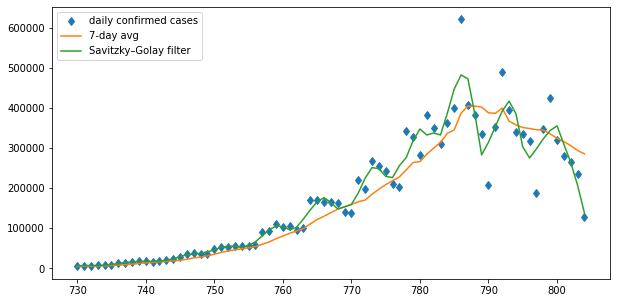

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(df.counts[730:], 'd', label="daily confirmed cases")
df.rolling_avg[730:].plot(label="7-day avg")
df.savgol[730:].plot(label="Savitzky–Golay filter")
plt.legend()

## skewed normal fifting using original data

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 182
    # data points      = 35
    # variables        = 4
    chi-square         = 1.7735e+11
    reduced chi-square = 5.7211e+09
    Akaike info crit   = 790.112012
    Bayesian info crit = 796.333405
[[Variables]]
    amplitude:  13874621.0 +/- 1157192.40 (8.34%) (init = 1.363930e+07)
    center:     20.8947115 +/- 290.386545 (1389.76%) (init = 102.12)
    sigma:      14.3355442 +/- 55.8748601 (389.76%) (init = 22.41)
    gamma:     -0.23022396 +/- 27.1318999 (11785.00%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, gamma)     = -1.000
    C(center, sigma)     = 1.000
    C(sigma, gamma)      = -1.000
    C(amplitude, gamma)  = 0.162
    C(amplitude, center) = -0.160
    C(amplitude, sigma)  = -0.138


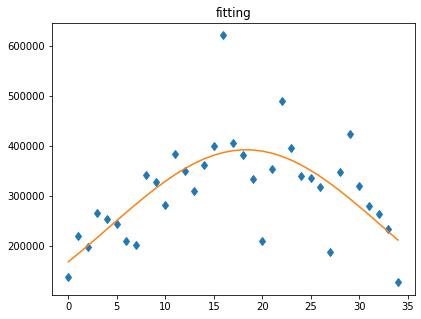

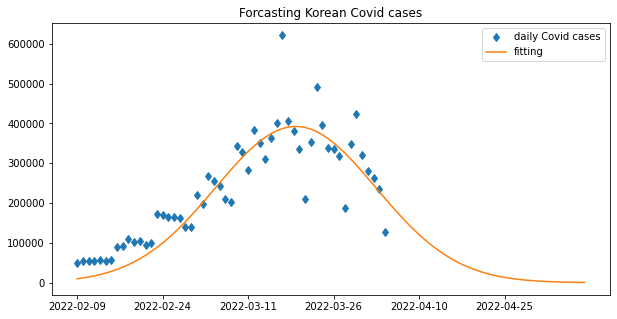

In [12]:
target_y = df.counts
start_idx = 770

skewed_gaussian_fitting_n_plot(target_y, start_idx, df, show_stats=True)
plt.savefig("./figs/fitting_n_prediction.png", facecolor="w")

## skewed normal fifting using 7-day rolling avg

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 309
    # data points      = 40
    # variables        = 4
    chi-square         = 1.0521e+10
    reduced chi-square = 2.9224e+08
    Akaike info crit   = 783.509461
    Bayesian info crit = 790.264979
[[Variables]]
    amplitude:  14599216.6 +/- 362979.748 (2.49%) (init = 1.363930e+07)
    center:     38.5262762 +/- 1.00749553 (2.62%) (init = 102.12)
    sigma:      21.1774285 +/- 1.31527955 (6.21%) (init = 22.41)
    gamma:     -1.60800161 +/- 0.43125036 (26.82%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = 0.967
    C(sigma, gamma)      = -0.918
    C(center, gamma)     = -0.872
    C(amplitude, gamma)  = 0.611
    C(amplitude, sigma)  = -0.286
    C(amplitude, center) = -0.220


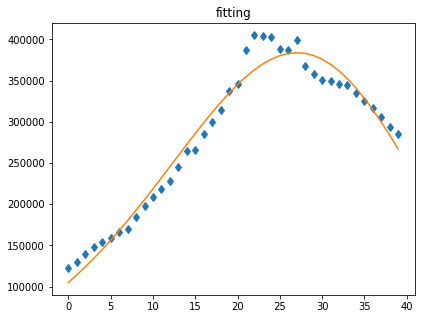

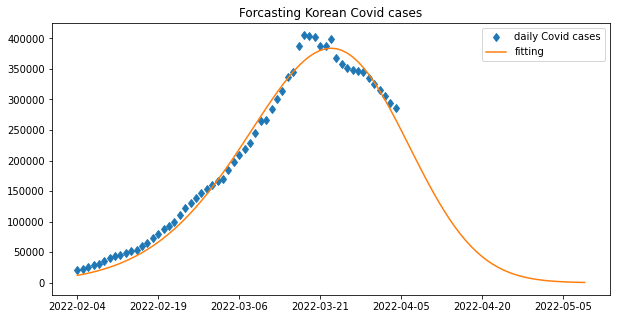

In [9]:
target_y = df.rolling_avg
start_idx = 765

skewed_gaussian_fitting_n_plot(target_y, start_idx, df, show_stats=True)

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 122
    # data points      = 40
    # variables        = 4
    chi-square         = 7.8173e+10
    reduced chi-square = 2.1715e+09
    Akaike info crit   = 863.732610
    Bayesian info crit = 870.488128
[[Variables]]
    amplitude:  14298409.2 +/- 645881.643 (4.52%) (init = 1.363930e+07)
    center:     35.2037176 +/- 2.57078568 (7.30%) (init = 102.12)
    sigma:      20.6182924 +/- 3.45042961 (16.73%) (init = 22.41)
    gamma:     -1.67065501 +/- 0.97832582 (58.56%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = 0.972
    C(sigma, gamma)      = -0.936
    C(center, gamma)     = -0.927
    C(amplitude, sigma)  = 0.170
    C(amplitude, center) = 0.135
    C(amplitude, gamma)  = 0.130


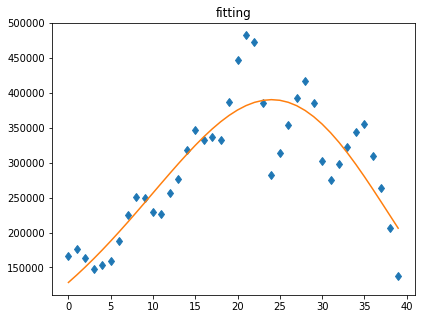

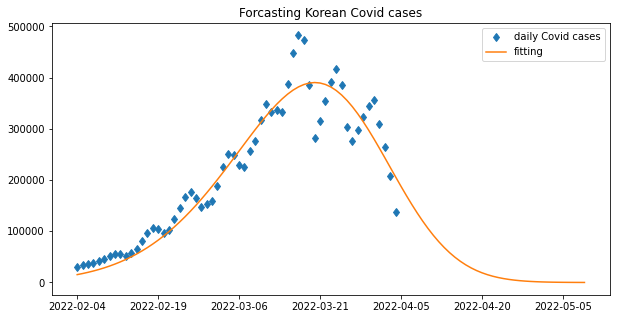

In [10]:
target_y = df.savgol
start_idx = 765

skewed_gaussian_fitting_n_plot(target_y, start_idx, df, show_stats=True)